<a href="https://colab.research.google.com/github/nguyenhads/Face_Regcognition/blob/master/face_reg_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
%cd /content/drive/My Drive/Real-time-multi-face-recognition-master

/content/drive/My Drive/Real-time-multi-face-recognition-master


In [127]:
%pwd

'/content/drive/My Drive/Real-time-multi-face-recognition-master'

# Face Recognition Project


### Content of this project

[**1. Introduction**](#ch1)

[**2. Details of selected FaceNet model**](#ch2)
   - [2.1. Computing the embedding vector](#ch2.1)
   - [2.2. The Triplet Loss](#ch2.2)
   
[**3. Applying the model**](#ch3)

[**4. Result and discussion**](#ch4)

[**References**](#REF)

<a id="ch1"></a>
## 1. Introduction

Face Recognition is one of very interesting application of deep neural networks, particularlly deep convolutional neural network.

A genneral face recognizier generally contains of two stages:
* Feature Extraction: to describe a face in an effective way
* Classification: to assign an identifier to a face

In deep learning regime, the CNN is often used for feature extraction and Fully-Connected (FC) network is used for face classification task (before an output layer). The details of the model is described in Fig. 1.

<img src="/content/drive/My Drive/Real-time-multi-face-recognition-master/Notebook_pictures/CNN_Structure.jpg" width="500"/>

<center> Fig. 1. The general architecture of Convolutional Neural Networks (CNN) Image Source: [1]. </center>

Recently, a noval network for more effectively and high accurary face recognition task has been proposed in [[2]](#ref2) which called as FaceNet. FaceNet system was introduced by Florian Schroff, Dmitry Kalenichenko and James Philbin at Google Inc. in 17 Jun 2015. This system achieved **99.63%** accuracy on **LFW dataset**, and **95.12%** accuracy on **YouTube Faces DB**. The results which were obtanined by FaceNet system are very impressive. Regarding the operation of FaceNet system, it directly leans a mapping from face images to a compact Euclidean space (vector of n numbers) where distances correspond to a measure of face similarity [[2]](#ref2). By comparing squared L2 distance in the embedding space for two pairs of anchor and positive to anchor and negative, the pictures are of the same person (anchor and positive) can be determined . Faces of the same person have small distances, while faces of diffrerent person have large distances. The structure of FaceNet can be visulized in Fig. 2. The Triplet Loss was used to minimize the distance between an anchor and positive which have the same identity, and maximize the distance between the anchor and a negative of a different identity [[2]](#ref2). The details of Triplet Loss will be discussed in details later.

<img src="/content/drive/My Drive/Real-time-multi-face-recognition-master/Notebook_pictures/FaceNetStructure.jpg" width="900"/>
<center>Fig. 2. Visulized structure of FaceNet system</center>

This project aims to **build a face recognition system to detect and identify multiple faces** in a selected picture based on the state-of-the-art **FaceNet system**. The structure of this project is motivated from the course: Convolutional Neural Networks of Prof. Andrew Ng in the series Deep Learning Specification - Course number 4 [[3]](#ref3).


## Import libraries

In [128]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model, load_model, model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import skimage as sk
import time

from facerecog_utils import *
from database_utils import *
from align import AlignDlib
from inception_blocks import *

<a id="ch2"></a>
## 2. Details of selected FaceNet model

<a id="ch2.1"></a>
### 2.1. Computing the embedding vector

The simplest way to do the face virification is by comparing two images pixel-by-pixel. However, this approach performs poorly, since the pixel values easily change due to variations of lighting, pose of face and many other factors. On another hand, the emdedding f(x) from an image x into a feature space Rd can produces a more accurate judgment by an element-wise comparision of the embedded vectors of images [[2]](#ref2). 

In this part, the ConvNet which are similar to inception model proposed by Szegedy.et.al [[4]](#ref4) will be used to compute encodings. The model has the name of `inception_blocks_v2.py` which was introduced and origin in [[3]](#ref3). This is a pretrained model, therefore it is not necessary to takes a lot of data and a long time training.

The model will take 96x96 dimensional RGB images as iputs, and output a matrix of shape (m,128) that encodes each input face image into a 128-dimensional vector. The reason why were 96x96 size of input images chosen were proposed in [[2]](#ref2). It is due to the balance of the FLOPS and Accuracy trade-off. A NN4 architecture (Inception model 96x96) can drastically reduce the CPU requirements (285M FLOPS vs 1.6B for NN2 architecture with 224x224 input images), while it can achieve the VAL accuracy of 82.0% ± 2.3 [[2]](#ref2). Additionally, the 128 dimensional vector was selected due to it can achieved about 87.9% ± 1.9 (highest accuracy) compared to 64, 256 and 512 dimensional vectors in fixed and reasonable training time [[2]](#ref2).


In [129]:
# Load the pretrained CNN models
FRmodel = faceRecoModel(input_shape=(3,96,96))
FRmodel.load_weights('Libraries/nn4.small2.v1.h5')
FRmodel.summary()

Model: "FaceRecoModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_299 (ZeroPadding (None, 3, 102, 102)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_299[0][0]         
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
______________________________________________________________________________________

<a id="ch2.2"></a>
### 2.2. Triplet 



# Generate data

In [141]:
# Generate the database
# time_start = time.time()
generate_database('Database/Train_Image', FRmodel, augmentations=3, output_name='database_0910.npy')
# time_end = time.time()
# print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

In [131]:
import numpy as np
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [132]:
# Load the database
face_dict_2 = np.load('database_ms.npy').item()

In [133]:
# restore np.load for future normal usage
np.load = np_load_old

Total run time: 964.17 ms


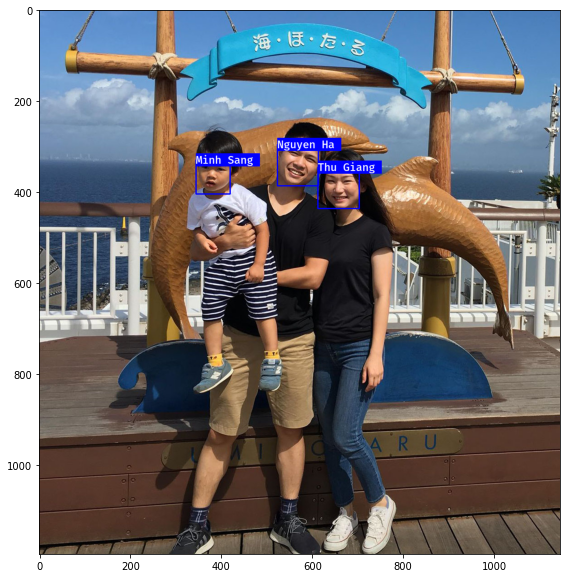

In [135]:
# Import image
img_path = 'Database/Test_Image/test_2.jpg'
image = import_image(img_path)

# Face recognition
time_start = time.time()
plt.figure(figsize=(15,10))
face_out = face_recognition(image, FRmodel, face_dict_2, plot=True, faces_out=True)
time_end = time.time()
print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

Total run time: 3227.24 ms


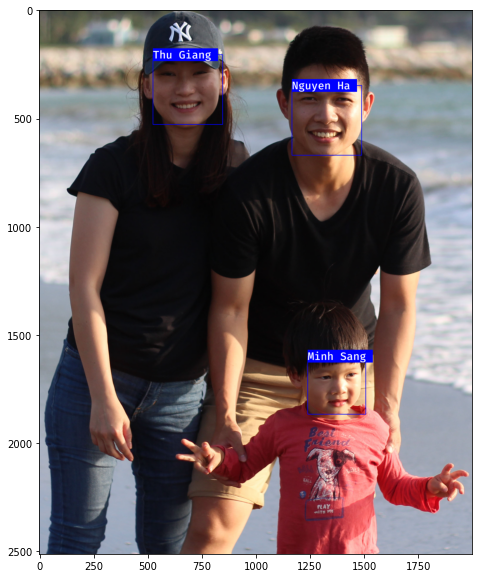

In [140]:
# Import image
img_path = 'Database/Test_Image/test_3.jpg'
image = import_image(img_path)

# Face recognition
time_start = time.time()
plt.figure(figsize=(15,10))
face_out = face_recognition(image, FRmodel, face_dict_2, plot=True, faces_out=True)
time_end = time.time()
print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

Total run time: 5145.93 ms


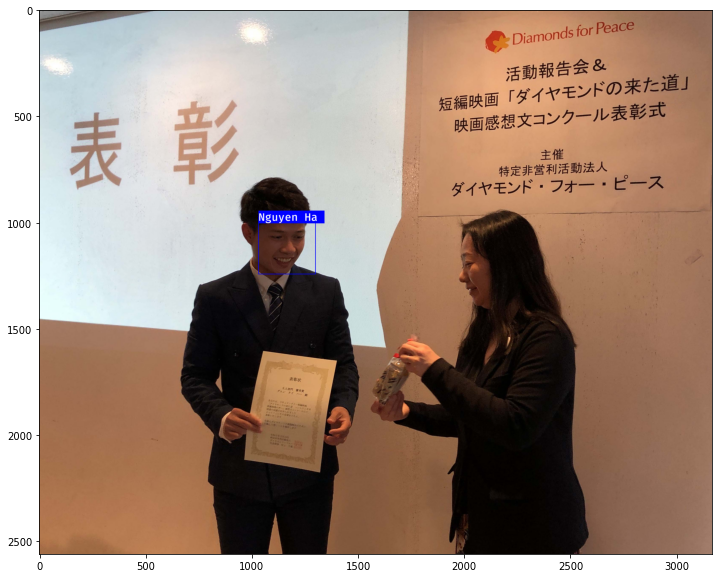

In [162]:
# Import image
img_path = 'Database/Test_Image/test_1.jpg'
image = import_image(img_path)

# Face recognition
time_start = time.time()
plt.figure(figsize=(15,10))
face_out = face_recognition(image, FRmodel, face_dict_2, plot=True, faces_out=True)
time_end = time.time()
print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

In [160]:
# for name in face_out.keys():
#     this_face = face_out[name]
#     fig = plt.figure()
#     plt.imshow(this_face)
#     plt.title(name)

<a id="REF"></a>
## References

<a id="ref1"></a>
1. https://www.analyticssteps.com/blogs/convolutional-neural-network-cnn-graphical-visualization-code-explanation

<a id="ref2"></a>
2. Flofian Schroff, Dmitry Kalenichenko and James Philbin, FaceNet: A Unified Embedding for Face Recognition and Clustering, 2015.

<a id="ref3"></a>
3. Andrew Ng, Deeplearning.AI

<a id="ref4"></a>
4. Y.Taigman, M.Yang, M.Ranzato, and L. Wolf. Deepface: Closing the gap to human-level performance in face verification. In IEEE Conf. on CVPR, 2014.

<a id="ref5"></a>
5. Szegedy.et.al

<a id="ref6"></a>
6. https://openface-api.readthedocs.io/en/latest/_modules/openface/align_dlib.html![image.png](attachment:image.png)